In [43]:
using GLMakie
using LaTeXStrings
using Logging

# Apagamos los warnings con Julia
Logging.disable_logging(Logging.Info)

LogLevel(1)

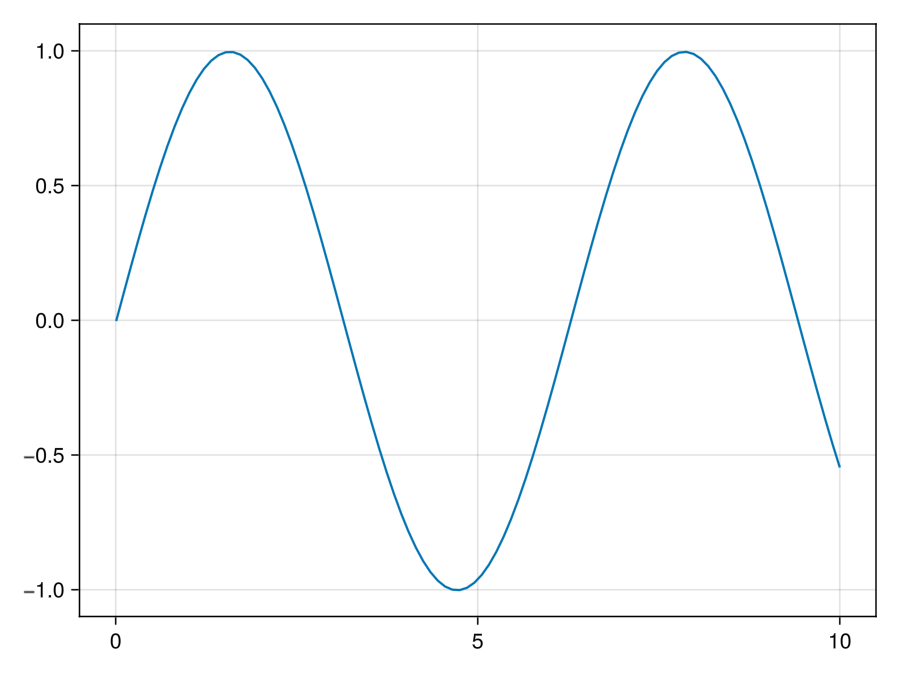

In [44]:
x = range(0, 10, length=100)
y = sin.(x)
lines(x, y)

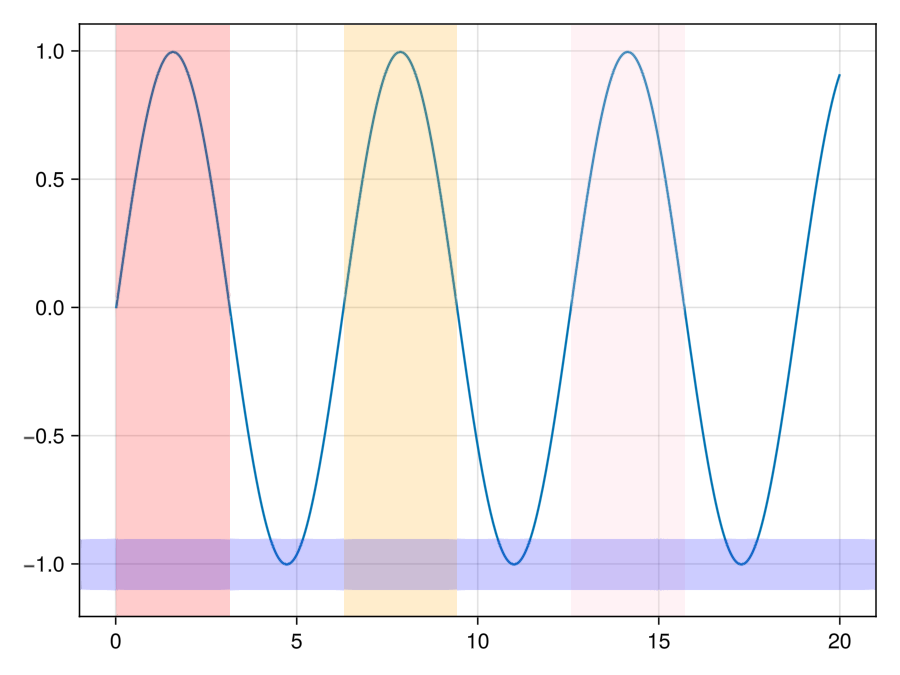

In [46]:
lines(0..20, sin)
vspan!([0, 2pi, 4pi], [pi, 3pi, 5pi],
color = [(c, 0.2) for c in [:red, =>orange, =>pink]])
hspan!(-1.1, -0.9, color = (=>blue, 0.2))
current_figure()

In [47]:
using GLMakie

# Definimos las funciones de probabilidad
function alpha_n(V)
    if abs(V - 10) < 0.01
        return 0.1
    end
    0.01 * (10 - V) / (exp((10 - V) / 10) - 1)
end


beta_n(V) = 0.125 * exp(-V / 80)


beta_n (generic function with 1 method)

Con [Wells]=>
* $C_m = 1.0\ \mu\text{F/cm}^2$ la capacitancia de la membrana por unidad de área
* $V$ la diferencia de potencial en la membrana
* $g_{Na} = 120\ \text{mS/cm}^2$ la conductancia máxima por unidad de área para el sodio
* $g_{K} = 36\ \text{mS/cm}^2$ la conductancia máxima por unidad de área para el potasio
* $g_{L} = 0.3\ \text{mS/cm}^2$ la conductancia adicional, independiente del voltaje
* $E_{Na} = 55\ \text{mV}$ el voltaje de la batería en la compuerta de sodio
* $E_{K} = -72\ \text{mV}$ el voltaje de la batería en la compuerta de potasio
* $E_{L} = -49.387\ \text{mV}$ el voltaje filtrado
* $\gamma(T)$ es una constante de proporcionalidad temporal que depende de la temperatura $T$, a $6.3°$C vale $1$ [Cessac2009].

para el caso del calamar.  Los potenciales están medidos considerando que la membrana se encuentra en su potencial de reposo a los $V_r = -60\ \text{mV}$.  Las corrientes $I$ están medidas en $\mu$A/cm$^2$.

Las funciones de transición $\alpha(V)$ y $\beta(V)$, fueron determinadas experimentalmente.  Su forma general es=>
\begin{align}
  \alpha(V) \text{ ó } \beta(V) = \frac{A + BV}{C + H e^{\left(\frac{V+D}{F}\right)}}
\end{align}
donde $V$ está medido con respecto al potencial de reposo $V_r$

Los valores medidos por Hodkin y Huxley para la compuerta de **potasio (K)**, fueron=>
\begin{align}
  \alpha_n(V) &= \frac{0.01(10 - V)}{e^{\left(\frac{10-V}{10}\right)} - 1} & \beta_n(V) &= 0.125 e^{-\frac{V}{80}}
\end{align}
Observemos que cuando $V = 10$ la función está indefinida.  Utilizando la regla de L'Hopital, se calcula el límite:
\begin{align}
  \alpha_n(10) &= \frac{-0.01}{e^{\left(\frac{10-V}{10}\right)}(-0.1)}
               = \frac{-0.01}{-0.1} = 0.1
\end{align}

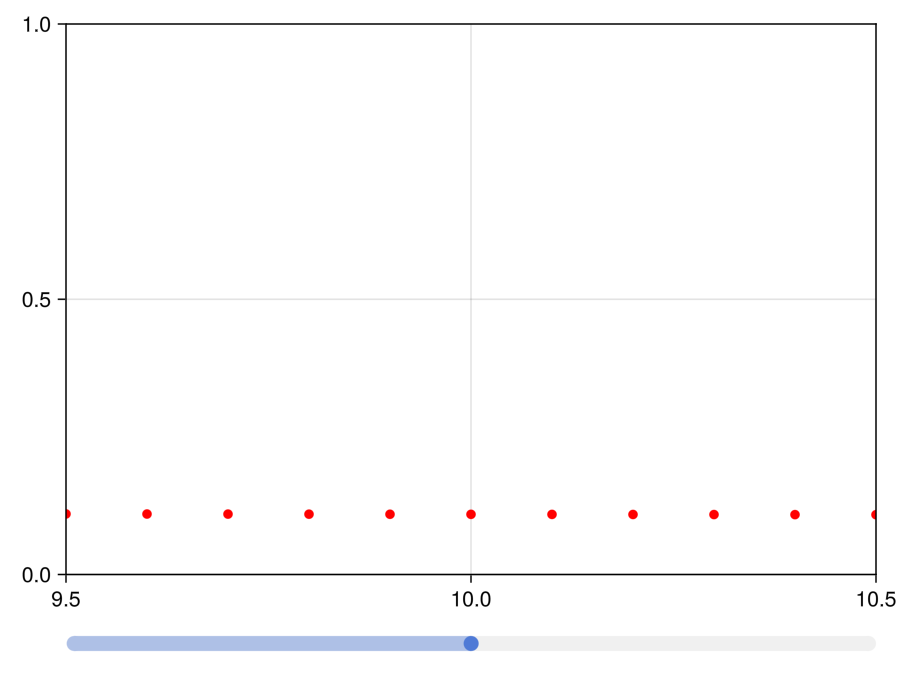

In [48]:
# TODO: Programar la función alpha_n como función del voltaje V.
#       Necesitarás definir un caso especial cuando V - 10 < epsilon
#       Utiliza esta celda para ver cómo se comporta tu función en esta vecindad.
#       ¿Qué pasa si epsilon = 0.1? ¿Y si epsilon = 0.01?
fig = Figure()
ax = Axis(fig[1, 1])
step_slider = Slider(fig[2, 1], range = 0.0001:0.0001:0.2, startvalue = 0.1)

min_x = 9.5
max_x = 10.5
min_y = 0
max_y = 1

points = lift(step_slider.value) do step
    xs = min_x:step:max_x
    ys = beta_n.(xs)
    res_points = [(x, y) for (x, y) in zip(xs, ys)]
    [Point2f(x, y) for (x, y) in res_points]
end

scatter!(points, color = :red, label="alpha_n(V)")

limits!(ax, min_x, max_x, min_y, max_y)

fig


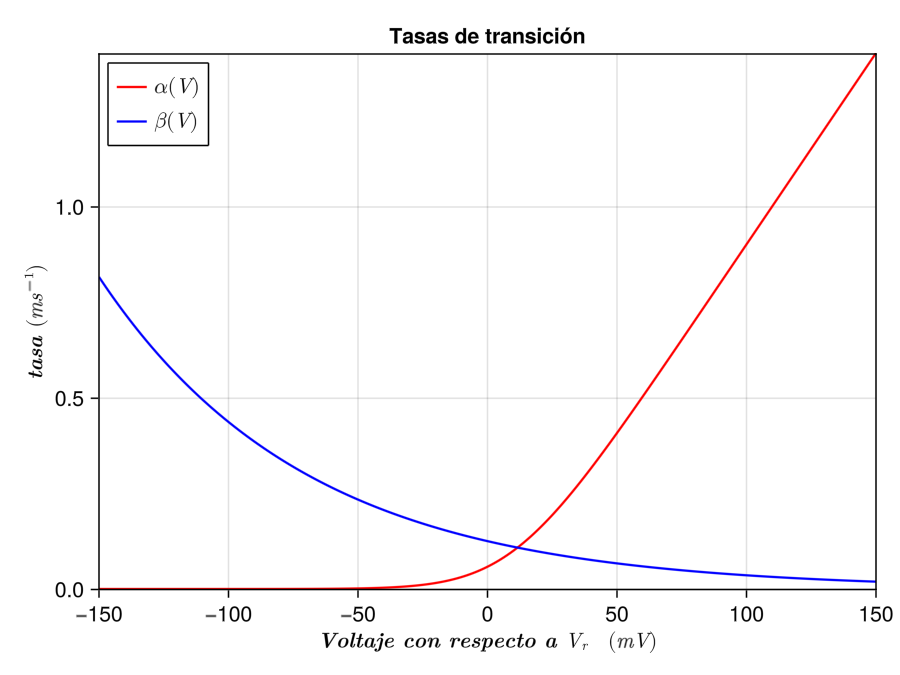

In [71]:
V = -150:0.1:150
alpha = alpha_n.(V)
beta = beta_n.(V)

fig = Figure()
ax = Axis(
    fig[1, 1],
    title="Tasas de transición",
    xlabel=L"\textbf{Voltaje con respecto a } V_r \quad (mV)",
    ylabel=L"\textbf{tasa } (ms^{-1})",)

lines_red = lines!(V, alpha, color=:red, label=L"\alpha(V)")
lines_blue = lines!(V, beta, color=:blue, label=L"\beta(V)")

axislegend(ax, position=:lt)

limits!(ax, -150, 150, 0, 1.4)

#=
Legend(
    fig[1, 2],
    [lines_blue, lines_red],
    [L"\alpha(V)", L"\beta(V)"]
)
=#

fig

Las funciones para el **sodio (Na)** son:
\begin{align}
  \alpha_m(V) &= \frac{0.1(25 - V)}{e^{\left(\frac{25-V}{10}\right)} - 1} & \beta_m(V) &= 4 e^{-\frac{V}{18}} \\
  \alpha_h(V) &= 0.07 e^{-\frac{V}{20}} & \beta_h(V) &= \frac{1}{e^{\left(\frac{30-V}{10}\right)} + 1}
\end{align}
Para $\alpha_m$ cuando $V = 25$, utilizamos la regla de L'Hopital para calcular el límite:
\begin{align}
  \alpha_m(25) &= \frac{-0.1}{e^{\left(\frac{25-V}{10}\right)}(-0.1)}
               = \frac{-0.1}{-0.1} = 1
\end{align}

In [134]:
include("./funciones.jl")

tau_inf (generic function with 2 methods)

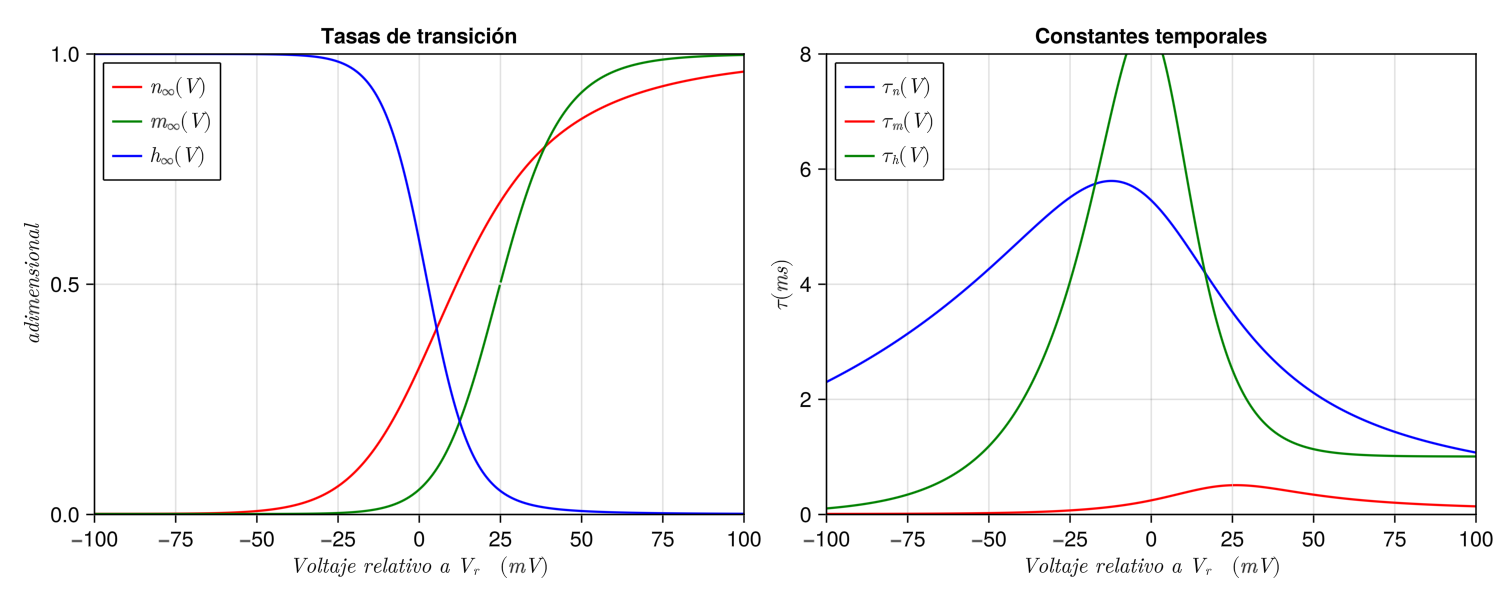

In [122]:
V = -150:0.1:150
alpha = alpha_n.(V)
beta = beta_n.(V)

f = Figure(size=(1000, 400))

axess = [
    Axis(f[1, 1],
        title="Tasas de transición",
        xlabel=L"\textit{Voltaje relativo a } V_r \quad (mV)",
        ylabel=L"adimensional",
        xticks=[-100, -75, -50, -25, 0, 25, 50, 75, 100]
    ),
    Axis(f[1, 2],
        # xscale = Makie.Symlog10(10.0),
        title="Constantes temporales",
        xlabel=L"\textit{Voltaje relativo a } V_r \quad (mV)",
        ylabel=L"\tau (ms)",
        xticks=[-100, -75, -50, -25, 0, 25, 50, 75, 100],
    )
]

alpha = alpha_n.(V)
beta = beta_n.(V)
lines!(axess[1], V, n_inf(alpha, beta), color=:red, label=L"n_{\infty}(V)")
lines!(axess[2], V, tau_inf(alpha, beta), color=:blue, label=L"\tau_{n}(V)")

alpha = alpha_m.(V)
beta = beta_m.(V)
lines!(axess[1], V, n_inf(alpha, beta), color=:green, label=L"m_{\infty}(V)")
lines!(axess[2], V, tau_inf(alpha, beta), color=:red, label=L"\tau_{m}(V)")

alpha = alpha_h.(V)
beta = beta_h.(V)
lines!(axess[1], V, n_inf(alpha, beta), color=:blue, label=L"h_{\infty}(V)")
lines!(axess[2], V, tau_inf(alpha, beta), color=:green, label=L"\tau_{h}(V)")


limits!(axess[1], -100, 100, 0, 1.0)
limits!(axess[2], -100, 100, 0, 8.0)
axislegend(axess[1], unique=false, merge=true, position=:lt)
axislegend(axess[2], unique=false, merge=true, position=:lt)

f

## Simulación con el método numérico de Euler

El método de Euler realiza una aproxima a la función por su tangente.  Dada una ecuación diferencial de la forma:

\begin{align}
  \frac{dy(t)}{dt} = f(y(t))
\end{align}

Partimos de un punto inicial $(t_0, y_0)$ y a partir de él, se calcula el valor de $y$ para el tiempo $t + \Delta t$ iterativamente como:

\begin{align}
  y(t + \Delta t) &= y(t) + \Delta t f(y(t))
\end{align}

El error aproximado por realizar esta aproximación es:
\begin{align}
  E =& \frac{1}{2} \frac{df(t)}{dt}(\Delta t)^2
\end{align}

Aplicando esta fórmula a la ecuación para los canales:

\begin{align}
 \frac{dn}{dt} &= \frac{n^{\infty}(V) - n}{\tau_n(V)}
\end{align}

Obtenemos:

\begin{align}
 n(t + \Delta t) =& n(t) + \Delta t \left[\frac{n^{\infty}(V)}{\tau_n} - \frac{n(t)}{\tau_n(V)} \right] \\
                 =& \left[ 1 - \frac{\Delta t}{\tau_n(V)} \right] n(t) + \frac{\Delta t}{\tau_n(V)}n^{\infty}(V)
\end{align}

Se obtienen fórmulas análogas para $m$ y $h$.

Se debe realizar el mismo procedimiento con la ecuación diferencial para el voltaje.  Para simplificar la notación, introduzcamos:

\begin{align}
  G_{Na} &= g_{Na}m^3h   &   G_{K} &= g_K n^4
\end{align}

Entonces:
\begin{align}
 C_m \frac{dV}{dt} &= -g_{Na}m^3h(V-E_{Na}) - g_K n^4 (V - E_K) - g_L (V - E_L) + I_{ext} \\
 \frac{dV}{dt} &= -\frac{G_{Na}}{C_m}(V-E_{Na}) - \frac{G_K}{C_m} (V - E_K) - \frac{g_L}{C_m} (V - E_L) + \frac{1}{C_m}I_{ext}
\end{align}

Utilizando el método de Euler:

\begin{align}
 V(t + \Delta t) &= V(t) - \frac{\Delta t \left[ G_{Na}(V-E_{Na}) + G_K (V - E_K) + g_L (V - E_L) + I_{ext}(t) \right]}{C_m}
\end{align}

Para asignar los valores iniciales, asumiremos que el valor $V(0)$ es dado, por lo que los valores iniciales de las $\alpha$, $\beta$ se calculan a partir de él.  Para los valores de $n,m$ y $h$ asumiremos que se llegó al equilibrio y se usarán $n_{\infty},m_{\infty}$ y $h_{\infty}$.


Para los valores por defecto propuestos en la celda siguiente, programar una simulación utilizando el método de Euler produce la figura siguiente:

<img src="./figuras/Simulacion.png">

In [133]:
parametros = Dict(
    "DeltaT" => 0.01,  # ms
    "maxT" => 50.0,  # ms    
    "V0" => 0.0,  # mV
    "gNa" => 120.0,  # mS/cm2
    "gK" => 36.0,
    "gL" => 0.3,
    "Cm" => 1.0,  # micro F/cm2
    "ENa" => 115.0,  # Utilizando la convensión original de Hodkin-Huxley
    "EK" => -12.0,
    "EL" => 10.613
)

function makeIext(t0=10.0, tfin=16.0, current=6.5)
    """
    Crea una función que representa la corriente externa aplicada al modelo de Hodgkin-Huxley.
    """
    function Iext(t)
        if t0 <= t <= tfin
            return current
        else
            return 0.0
        end
    end

    return Iext
end


# TODO: Implementar el algoritmo de integración numérica de Euler partialsort
# calcular V(t)

# Asegurate de que, al ejecutar la simulación con los parémtros por defecto,
# se reproduce la imagen de arriba

# Después prueba con pulsos de t en 10 -> 30, con corrientes de 10 y -10
# microamperes. ¿Qué observas?

# Inserta al final una celda con tus comentarios y resultados

V0_slider = Slider(fig[2, 2], range = -90:1:120, startvalue = parametros["V0"])
curent_slider = Slider(fig[2, 3], range = -10:0.1:10, startvalue = 2.4)

t0 = 10.0
t_fin = 16.0

points = lift(step_slider.value) do step
    xs = min_x:step:max_x
    ys = beta_n.(xs)
    res_points = [(x, y) for (x, y) in zip(xs, ys)]
    [Point2f(x, y) for (x, y) in res_points]
end


function plot_simulation(resultado)
    fig = Figure()
    axez = [
        Axis(fig[1, 1],
            title="Simulación del modelo de Hodgkin-Huxley",
            xlabel=L"\textit{Tiempo } (ms)",
            ylabel=L"\textit{Voltaje } (mV)",
            xticks=[0, 10, 20, 30, 40, 50]
        ),
        Axis(fig[1, 2],
            title="Corriente aplicada",
            xlabel=L"\textit{Tiempo } (ms)",
            ylabel=L"\textit{Corriente } (\mu A/cm^2)",
            xticks=[0, 10, 20, 30, 40, 50]
        )
    ]
end

function simula_hodgkin_huxley(V0, t0, t_fin, current)
    parametros["V0"] = makeIext(t0, t_fin, current)
    parametros["V0"] = V0
    resultado = EulerHodkinHuxley(parametros)
    plot_simulation(resultado)
end

function EulerHodkinHuxley(parametros)
    println(parametros)
end


EulerHodkinHuxley (generic function with 1 method)